## Imports

In [1]:
from class_definitions import Program, Merit, Target, Observation, Plan, Night
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import astroplan
from astropy.time import Time, TimeDelta
from astropy.coordinates import SkyCoord, AltAz
import merits
import astropy.units as u
from tqdm.notebook import tqdm
import scheduler
from datetime import date, timedelta, datetime
import pickle
from helper_functions import load_program, build_observations

## Setup

In [2]:
# Define global observer location
lasilla = astroplan.Observer.at_site("lasilla")

In [3]:
# Define the programs
# Eventually this would be imported from the gitlab with the files.
prog600 = Program(600, 2, instrument="CORALIE")
prog703 = Program(703, 13, instrument="CORALIE")
prog708 = Program(708, 7, instrument="CORALIE")
prog714 = Program(714, 2, instrument="CORALIE")

In [4]:
start_datetime = Time("2023-10-20 03:00:00")

In [5]:
# Time(datetime.combine(date(2023, 10, 20), datetime.min.time()))
start_datetime.datetime.date()

night = Night(start_datetime.datetime.date() - timedelta(days=1), observations_within='nautical')

### Define the merits

In [6]:
# Define merits
cadence_merit = Merit("Cadence", merits.cadence, 
                      merit_type="efficiency", 
                      parameters={"delay": TimeDelta(4*u.day), "alpha":0.05})
airmass_merit = Merit("Airmass", merits.airmass, merit_type="veto", parameters={'max':1.8})
altitude_merit = Merit("Altitude", merits.altitude, merit_type="veto")
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto")
culmination_merit = Merit("Culmination", merits.culmination, merit_type="efficiency")
egress_merit = Merit("Egress", merits.egress, merit_type="efficiency")

In [7]:
merits_list = [airmass_merit, altitude_merit, 
               at_night_merit, culmination_merit, egress_merit]

### Load the targets

In [8]:
pct_keep = 0.75

Targets from 600

In [9]:
targets_600 = load_program("programs/Prog600COR_2023-10-19_obsinfo.csv", 
                           prog600, merits_list, pct_keep=pct_keep)
len(targets_600)

4

Targets from 708

In [10]:
targets_708 = load_program("programs/Prog708COR_2023-10-19_obsinfo.csv", 
                           prog708, merits_list, pct_keep=pct_keep)
len(targets_708)

15

Targets from 714

In [11]:
targets_714 = load_program("programs/Prog714COR_2023-10-19_obsinfo.csv", 
                           prog714, merits_list, pct_keep=pct_keep)
len(targets_714)

64

### Build the observations

In [12]:
# Merge the two programs
targets_all = targets_600 + targets_708 + targets_714

In [13]:
obs_600 = build_observations(targets_600, start_datetime, 
                             night, TimeDelta(20*u.min), "programs/obs_600.pkl")

In [14]:
obs_708 = build_observations(targets_708, start_datetime, 
                             night, TimeDelta(15*u.min), "programs/obs_708.pkl")

In [15]:
obs_714 = build_observations(targets_714, start_datetime, 
                             night, TimeDelta(15*u.min), "programs/obs_714.pkl")

In [16]:
test_observations = obs_600 + obs_708 + obs_714

## Test the merits

In [17]:
test_obs = test_observations[0]
print(test_obs)
print(test_obs.target)

Observation(Target: HD1581,
            Start time: 2460237.625,
            Exposure time: 0.013888888888888888,
            Score: 0.0)
Target(Name: HD1581,
       Program: 600,
       Coordinates: <SkyCoord (ICRS): (ra, dec) in deg
    (5.01791667, -64.87472222)>,
       Last observation: 2460178.84805948,
       Priority: 1.0,
       Merits: [Merit(Airmass, veto, {'max': 1.8}), Merit(Altitude, veto, {}), Merit(AtNight, veto, {}), Merit(Culmination, efficiency, {}), Merit(Egress, efficiency, {})],


In [18]:
print(f"Cadence merit = {cadence_merit.evaluate(test_obs, verbose=True)}")

observation.start_time = 2460237.625
observation.target.last_obs = 2460178.84805948
delay.value = 4.0
Cadence merit = 2.840447404235384


In [19]:
print(f"Airmass merit = {airmass_merit.evaluate(test_obs, verbose=True)}")

Airmass merit = 1.0


In [20]:
print(f"Altitude merit = {altitude_merit.evaluate(test_obs)}")

Altitude merit = 1.0


In [21]:
print(f"Culmination merit = {culmination_merit.evaluate(test_obs, verbose=True)}")

Current altitude: 54.47529253685186
Max altitude: 54.51171089210749
Min altitude: 26.500720105594215
Altitude proportion: 0.9986998547986685
Culmination merit = 0.9986998547986685


In [22]:
print(f"Egress merit = {egress_merit.evaluate(test_observations[16], verbose=True)}")

Current time: 2460237.625
First time: 2460237.5760950577
Last time: 2460238.043685746
Observable range proportion: 0.10458921354991348
Egress merit = 0.10458921354991348


In [23]:
test_obs.evaluate_score(verbose=True)

Current altitude: 54.47529253685186
Max altitude: 54.51171089210749
Min altitude: 26.500720105594215
Altitude proportion: 0.9986998547986685
Current time: 2460237.625
First time: 2460237.3400395173
Last time: 2460237.925030735
Observable range proportion: 0.4871192492576575
Fairness: 1.0
Sensibility: 1.0
Efficiency: 0.742909552028163
Rank score: 0.742909552028163


0.742909552028163

# Test the Schedulers

## Simple greedy search

In [24]:
# Create the plan
plan_start = Time(night.nautical_evening, format='jd')
plan = scheduler.forwardP(plan_start, test_observations, 20)

In [25]:
print(f"Length = {len(plan)}")
print(f"Score = {plan.evaluate_plan():.6f}")
plan.calculate_overhead()
print(f"Overhead time = {plan.overhead_time:.5f}")
print(f"Observation time = {plan.observation_time:.5f}")
print(f"Overhead ratio = {plan.overhead_ratio:.5f}")

Length = 20
Score = 0.735324
Overhead time = 0.20465 h
Observation time = 5.16667 h
Overhead ratio = 0.03961


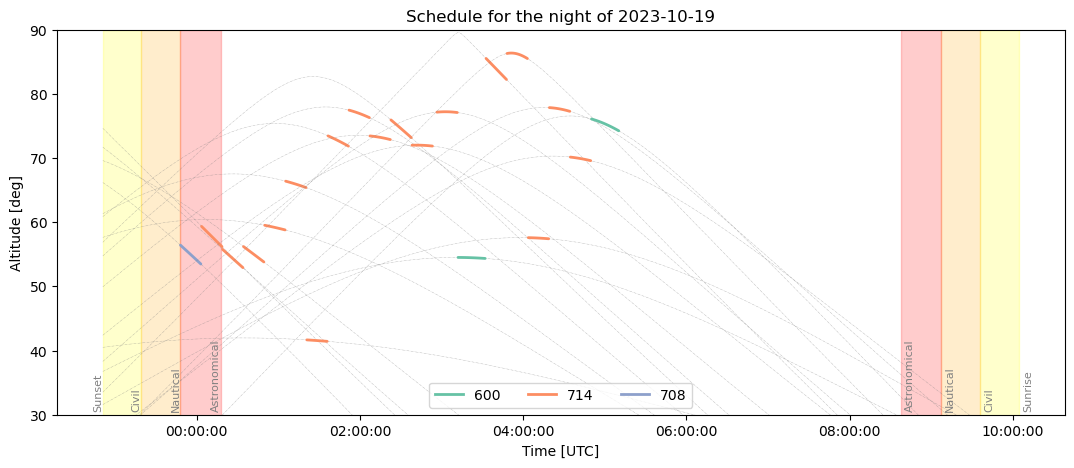

In [26]:
plan.plot()

## Recursive Dynamic Programming

In [27]:
# dpplanner = scheduler.DPPlanner()

# dpplan = dpplanner.dp_recursion(test_observations_noegress, 
#                                 Plan(), 
#                                 max_plan_length=10,
#                                 K = 4)

In [28]:
# print(f"Total recursion calls: {dpplanner.total_counter}")
# print(f"Saved recursion calls: {dpplanner.saved_state_counter}")

# print(dpplan[1])

In [29]:
# dpplan[1].plot()

## Beam Search

In [33]:
beamsearch = scheduler.BeamSearchPlanner(plan_start.jd)

bs_plan = beamsearch.dp_beam_search(test_observations, 
                                    max_plan_length=10, 
                                    K=5)

Went through the 0 level
Went through the 1 level
Went through the 2 level
Went through the 3 level
Went through the 4 level
Went through the 5 level
Went through the 6 level
Went through the 7 level
Went through the 8 level
Went through the 9 level


In [34]:
print(f"Length = {len(bs_plan)}")
print(f"Score = {bs_plan.evaluate_plan():.6f}")
bs_plan.calculate_overhead()
print(f"Overhead time = {bs_plan.overhead_time:.5f}")
print(f"Observation time = {bs_plan.observation_time:.5f}")
print(f"Overhead ratio = {bs_plan.overhead_ratio:.5f}")

Length = 10
Score = 0.757695
Overhead time = 0.07038 h
Observation time = 2.50000 h
Overhead ratio = 0.02815


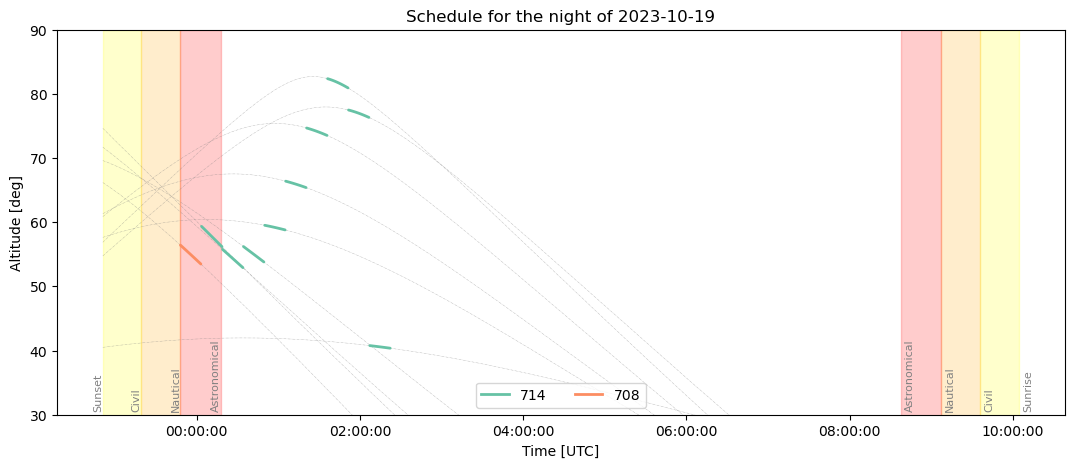

In [35]:
bs_plan.plot()